In [1]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt  
import statsmodels.api as sm
import itertools

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D



from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error




In [3]:
import os
BIGQUERY_PROJECT = 'cloud-test-ironhacks'
BIGQUERY_KEYPATH = '../../../cloud-test-ironhacks-5411cc5ba9ae.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEYPATH
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [4]:
query = """
SELECT * FROM `cloud-test-ironhacks.weather.combined_weather`
"""

query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
data.head()

,date,max_rel_humidity,max_temperature,mean_temperature,min_rel_humidity,min_temperature,potential_water_deficit,precipitation_data,wind_speed
0,2019-08-10,90.5813,28.3985,21.5126,39.8397,14.6268,-4.8887,0.0,2.1004
1,2019-08-24,91.3571,24.6652,18.6607,44.4712,12.6562,-4.7381,0.0,4.4706
2,2019-08-28,93.9562,25.3146,18.8246,43.4746,12.3346,-4.7147,0.0,4.3852
3,2019-09-04,99.9498,25.4570,18.6242,56.4720,11.7913,-3.6142,0.0,3.6461
4,2019-09-17,96.1398,26.9347,20.6516,46.6763,14.3685,-4.1923,0.0,4.0712


In [5]:
cols = ['max_rel_humidity', 'mean_temperature', 'min_rel_humidity', 'min_temperature', 'potential_water_deficit', 'precipitation_data', 'wind_speed']
data.drop(cols, axis=1, inplace=True)

In [6]:
data = data.groupby('date')['max_temperature'].sum().reset_index()

In [7]:
data['date'] = pd.to_datetime(data['date'])
data.set_index(['date'],inplace=True)

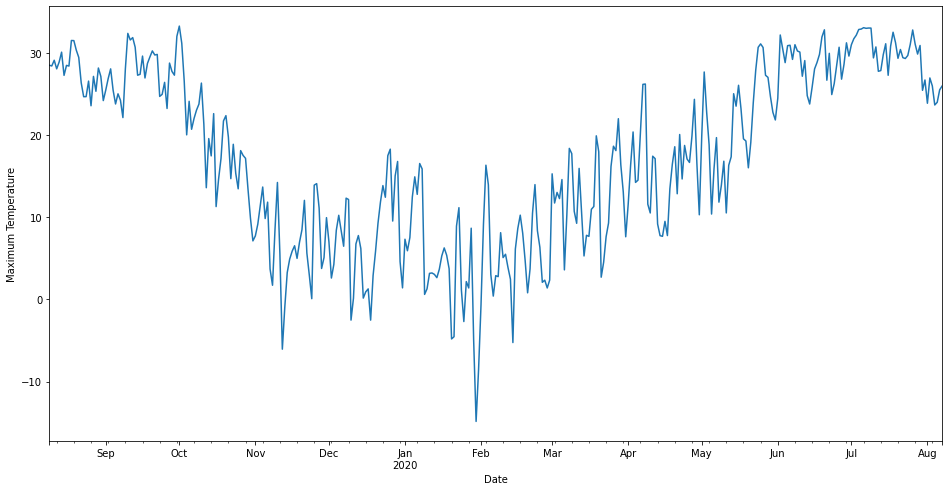

In [8]:
df = pd.DataFrame(data)
plt.figure(figsize=(16,8))
df['max_temperature'].plot()
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-08-09 to 2020-08-07
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   max_temperature  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [10]:
df_1=df.values
df_1=df_1.astype('float32')

scaler = MinMaxScaler(feature_range=(-1,1))
ts = scaler.fit_transform(df_1)



In [11]:
timestep = 30

X= []
Y=[]

raw_data=ts

for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 20
Xtrain = X[:k,:,:]  
Ytrain = Y[:k]    

In [12]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(30, 1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(Xtrain, Ytrain, epochs=200, verbose=0)

In [13]:
Xtest = X[k:,:,:]  
Ytest= Y[k:]  

In [14]:
preds = model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

print(mean_squared_error(Ytest,preds))

82.655014


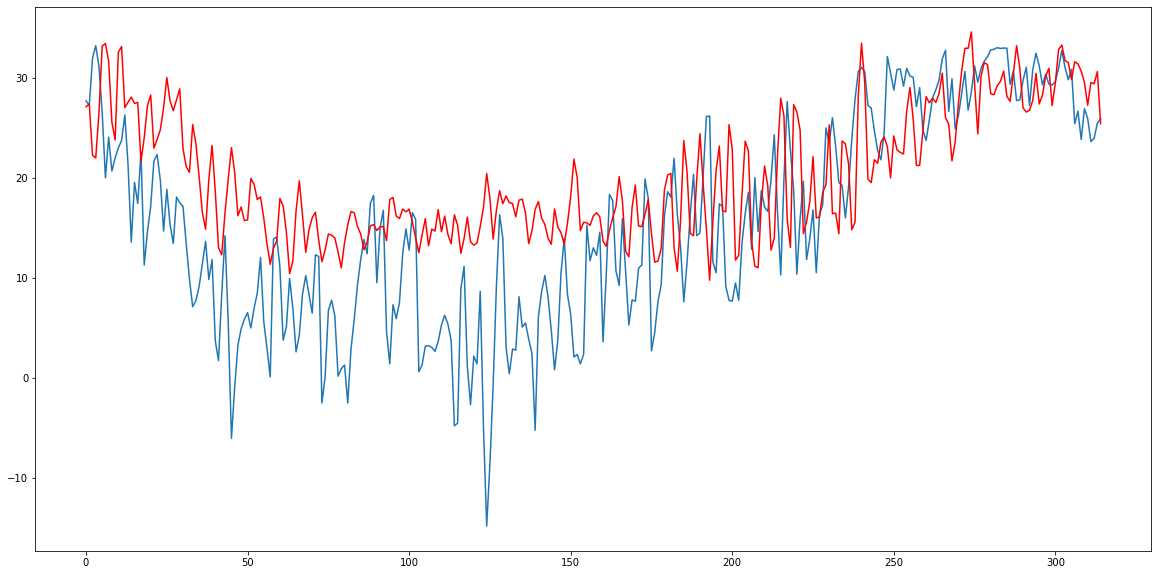

In [15]:
from matplotlib import pyplot
pyplot.figure(figsize=(20,10))
pyplot.plot(Ytest)
pyplot.plot(preds, 'r')
pyplot.show()